# Active User - users_df의 timestamp_first_active 이용
# 마케팅 채널별(affili_channel)로 Active User를 계산해보자. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

%matplotlib inline

# matplotlib 한글 깨짐 해결
plt.rcParams['font.family'] = 'AppleGothic' # For MacOS
plt.rcParams['axes.unicode_minus'] =False

# Seaborn 폰트 설정
sns.set(font='AppleGothic') # 사용하고 있는 한글 폰트로 변경

print(plt.rcParams['font.family'])

['AppleGothic']


In [2]:
users_df = pd.read_csv('airbnb-recruiting-new-user-bookings/users_df.csv')
sessions_df = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv')
countries_df = pd.read_csv('airbnb-recruiting-new-user-bookings/countries.csv')
age_gender_df = pd.read_csv('airbnb-recruiting-new-user-bookings/age_gender_bkts.csv')

In [3]:
# date_account_created, timestamp_first_active, date_first_booking를 날짜 형식으로 변환
users_df['date_account_created'] = pd.to_datetime(users_df['date_account_created'])
users_df['timestamp_first_active'] = pd.to_datetime(users_df['timestamp_first_active'], errors='coerce')
users_df['date_first_booking'] = pd.to_datetime(users_df['date_first_booking'], errors='coerce')

# 변환이 제대로 되었는지 확인
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  object        
 5   age                      124522 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [4]:
users_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


### affiliate_channel : 유료 마케팅의 종류
이 컬럼은 사용자가 Airbnb에 유입된 채널을 나타냅니다. 주로 마케팅 캠페인이나 제휴 프로그램을 통해 사용자가 사이트에 방문한 경로를 의미합니다. 가능한 값들은 다음과 같습니다:

- `direct`: 직접 방문 (URL을 직접 입력하거나 북마크 등을 통해 방문)

- `sem-brand`: 브랜드 검색 광고 (브랜드 키워드에 대한 검색 엔진 마케팅)

- `sem-non-brand`: 비브랜드 검색 광고 (일반 키워드에 대한 검색 엔진 마케팅)

- `seo`: 검색 엔진 최적화 (검색 엔진을 통해 자연 검색 결과에서 방문)

- `api`: API를 통해 유입된 사용자

- `content`: 콘텐츠 마케팅 (블로그, 기사 등 콘텐츠를 통해 유입)

- `remarketing`: 리마케팅 캠페인 (이전에 방문한 사용자를 대상으로 한 광고)

- `other`: 기타 채널

In [6]:
users_df['affiliate_channel'].unique()

array(['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand',
       'remarketing', 'api'], dtype=object)

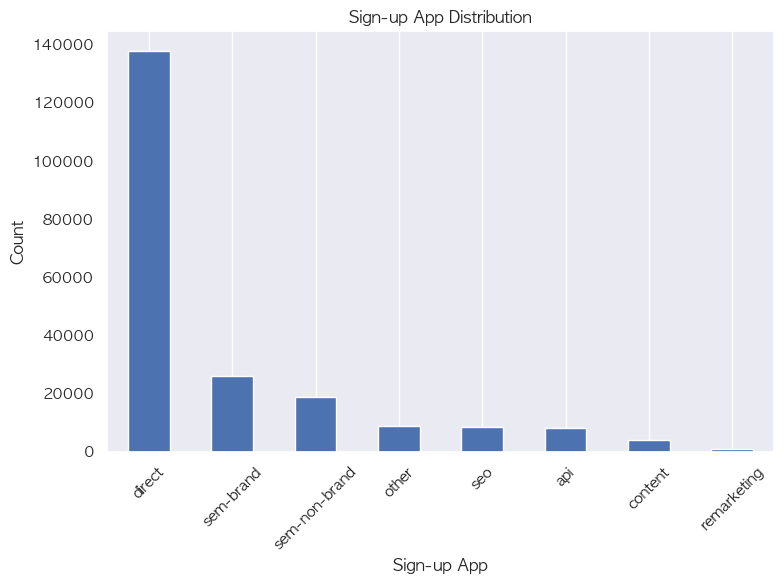

In [7]:
affiliate_channel_counts = users_df['affiliate_channel'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
affiliate_channel_counts.plot(kind='bar')
plt.title('Sign-up App Distribution')
plt.xlabel('Sign-up App')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### affiliate_channel을 기준으로 DAU, WAU, MAU를 구해보자. 

In [8]:
# 원하는 컬럼에 따라 active user을 구하는 함수
def calculate_active_users(users_df, group_col='affiliate_channel', freq='D'):
    # DAU 계산
    if freq == 'D':
        dau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        dau.columns = ['time', group_col, 'DAU']
        return dau

    # WAU 계산
    elif freq == 'W-MON':
        wau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        wau.columns = ['week', group_col, 'WAU']
        return wau

    # MAU 계산
    if freq == 'M':
        mau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        mau.columns = ['month', group_col, 'MAU']
        return mau


In [9]:
dau = calculate_active_users(users_df, group_col='affiliate_channel', freq='D')
dau

,time,affiliate_channel,DAU
0,2009-03-19,direct,1
1,2009-05-23,seo,1
2,2009-06-09,direct,1
3,2009-10-31,direct,1
4,2009-12-08,direct,1
...,...,...,...
9353,2014-06-30,other,10
9354,2014-06-30,remarketing,3
9355,2014-06-30,sem-brand,119
9356,2014-06-30,sem-non-brand,26


In [10]:
# dau.to_csv("airbnb-recruiting-new-user-bookings/tmp/dau.csv", index=False)

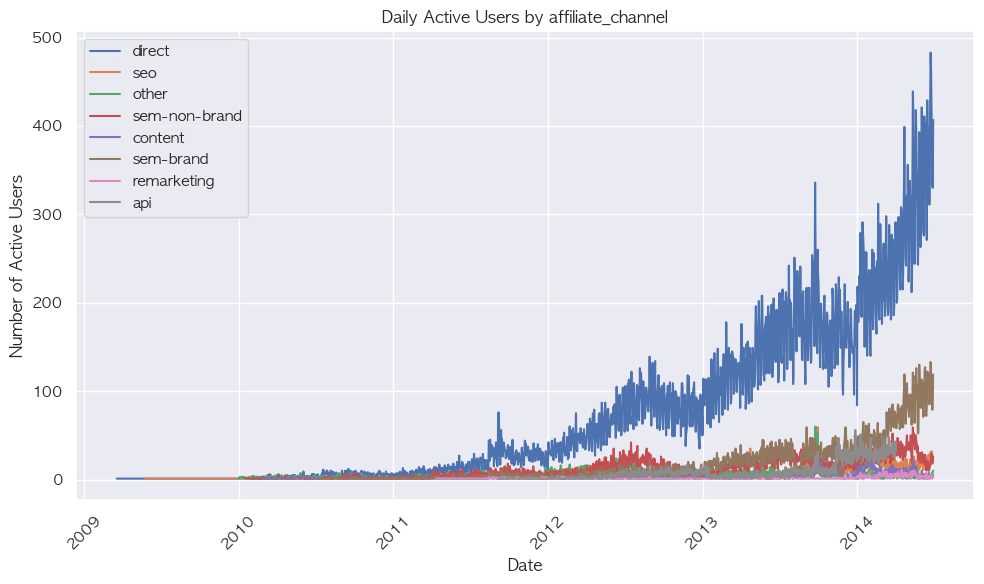

In [11]:
plt.figure(figsize=(10, 6))
for app in dau['affiliate_channel'].unique():
    app_data = dau[dau['affiliate_channel'] == app]
    plt.plot(app_data['time'], app_data['DAU'], label=app)

plt.title('Daily Active Users by affiliate_channel')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

## DAU 분석
### 전체적인 추세
전체 성장: 그래프에서 알 수 있듯이, 전체 DAU는 2012년 이후 꾸준히 증가하고 있으며, 특히 2013년부터 급격한 성장을 보이고 있습니다. 이는 Airbnb가 해당 기간 동안 사용자 수를 크게 늘렸음을 나타냅니다.

### 채널별 분석
- direct (직접 방문): 가장 큰 비중을 차지하며, 시간이 지남에 따라 꾸준히 증가하고 있습니다. 2013년 이후 급격한 증가세를 보이며, 사용자의 신뢰와 인지도가 크게 높아진 것으로 해석할 수 있습니다.

- seo (검색 엔진 최적화): 2011년 이후 점진적인 증가를 보입니다. 검색 엔진 최적화 노력이 결실을 보고 있으며, 자연 검색 결과에서의 유입이 꾸준히 증가하고 있습니다.

- sem-non-brand (비브랜드 검색 광고): 2012년 이후 점차 증가하고 있습니다. 비브랜드 키워드를 통한 검색 광고가 효과적으로 작동하고 있으며, 새로운 사용자 유입에 기여하고 있습니다.

- sem-brand (브랜드 검색 광고): 꾸준한 증가세를 보입니다. 브랜드 인지도가 높아지면서 브랜드 키워드를 통한 검색 광고의 효과도 높아지고 있음을 나타냅니다.

- content (콘텐츠 마케팅): 2012년 이후부터 조금씩 증가하고 있습니다. 블로그나 기사 등을 통한 콘텐츠 마케팅이 사용자 유입에 기여하고 있음을 알 수 있습니다.

- remarketing (리마케팅 캠페인): 비교적 낮은 비중을 차지하지만 점차 증가하는 추세입니다. 이전 방문자를 대상으로 한 광고가 재방문 유도에 효과적임을 나타냅니다.

- api (API): 거의 변동이 없고 비교적 낮은 비중을 차지합니다. API를 통한 유입은 다른 채널에 비해 크지 않음을 알 수 있습니다.

- other (기타 채널): 다른 채널들에 비해 다소 낮은 비중을 차지하고 있습니다. 특정한 마케팅 채널이 아닌 기타 경로를 통해 유입된 사용자가 점차 증가하고 있음을 나타냅니다.

### 종합 해석
- 주요 유입 경로: direct와 seo가 주요 유입 경로로, 이는 사용자의 자연스러운 방문이 많다는 것을 의미합니다.

- 마케팅 효과: sem-non-brand, sem-brand, content, remarketing 등의 마케팅 채널을 통해 유입된 사용자가 꾸준히 증가하고 있으며, 이는 마케팅 캠페인이 효과적이라는 것을 보여줍니다.

- 성장세: 전체적으로 모든 채널에서 DAU가 증가하고 있어, Airbnb의 전반적인 성장세가 긍정적입니다.

In [12]:
wau = calculate_active_users(users_df, group_col='affiliate_channel', freq='W-MON')
wau

,week,affiliate_channel,WAU
0,2009-03-23,direct,1
1,2009-05-25,seo,1
2,2009-06-15,direct,1
3,2009-11-02,direct,1
4,2009-12-14,direct,1
...,...,...,...
1607,2014-06-30,other,38
1608,2014-06-30,remarketing,20
1609,2014-06-30,sem-brand,766
1610,2014-06-30,sem-non-brand,149


In [13]:
# wau.to_csv("airbnb-recruiting-new-user-bookings/tmp/wau.csv", index=False)

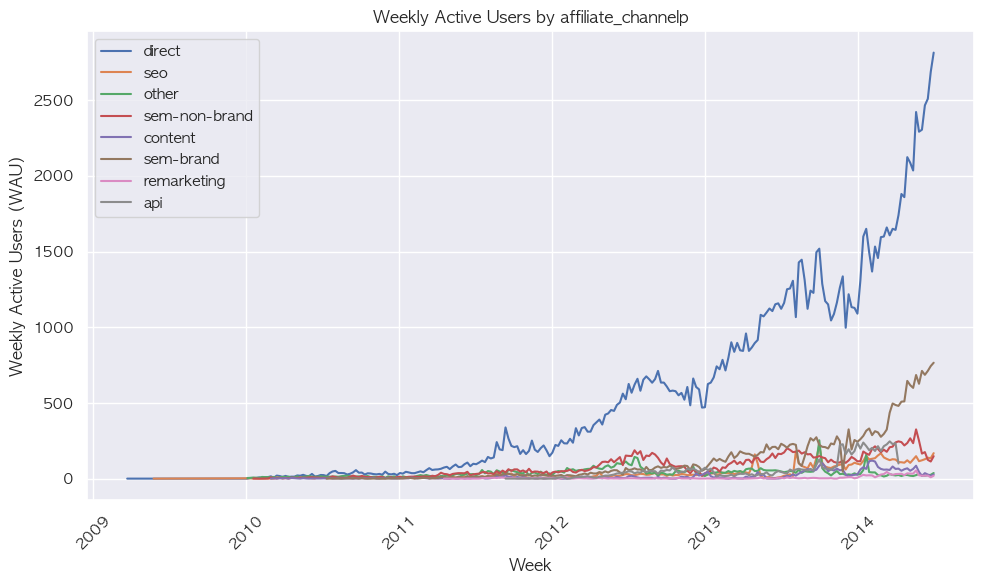

In [14]:
plt.figure(figsize=(10, 6))
for app in wau['affiliate_channel'].unique():
    app_data = wau[wau['affiliate_channel'] == app]
    plt.plot(app_data['week'], app_data['WAU'], label=app)

plt.title('Weekly Active Users by affiliate_channelp')
plt.xlabel('Week')
plt.ylabel('Weekly Active Users (WAU)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

## WAU 분석
### 전체적인 추세
- 전체 성장: 그래프에서 볼 수 있듯이, 전체 WAU는 2012년 이후 꾸준히 증가하고 있으며, 특히 2013년 이후 급격히 증가하고 있습니다. 이는 Airbnb의 사용자 기반이 해당 기간 동안 빠르게 성장했음을 나타냅니다.

### 채널별 분석
- direct (직접 방문): 가장 높은 비중을 차지하며, 시간이 지남에 따라 급격히 증가하고 있습니다. 2013년 이후 WAU가 눈에 띄게 증가하면서 사용자의 신뢰와 인지도가 크게 상승했음을 보여줍니다.

- seo (검색 엔진 최적화): 지속적인 증가세를 보입니다. 검색 엔진을 통한 자연 검색 결과의 유입이 꾸준히 증가하고 있음을 알 수 있습니다.

- sem-non-brand (비브랜드 검색 광고): 2012년 이후 점진적으로 증가하고 있습니다. 비브랜드 키워드를 통한 검색 광고가 새로운 사용자 유입에 지속적으로 기여하고 있습니다.

- sem-brand (브랜드 검색 광고): 점진적으로 증가하는 추세입니다. 브랜드 인지도가 높아짐에 따라 브랜드 검색 광고의 효과도 증가하고 있음을 나타냅니다.

- content (콘텐츠 마케팅): 꾸준한 증가세를 보입니다. 콘텐츠 마케팅을 통한 사용자 유입이 효과적임을 알 수 있습니다.

- remarketing (리마케팅 캠페인): 비교적 낮은 비중이지만, 점진적으로 증가하고 있습니다. 이전 방문자를 대상으로 한 광고 캠페인이 재방문 유도에 효과적임을 보여줍니다.

- api (API): 거의 변동이 없고 낮은 비중을 차지하고 있습니다. API를 통한 유입은 다른 채널에 비해 크지 않음을 나타냅니다.

- other (기타 채널): 다른 채널들에 비해 다소 낮은 비중을 차지하고 있으며, 점진적으로 증가하고 있습니다. 특정한 마케팅 채널이 아닌 기타 경로를 통해 유입된 사용자가 증가하고 있음을 나타냅니다.

### 종합 해석
- 주요 유입 경로: direct와 seo가 여전히 주요 유입 경로로, 이는 사용자의 자연스러운 방문이 많다는 것을 의미합니다.

- 마케팅 효과: sem-non-brand, sem-brand, content, remarketing 등의 마케팅 채널을 통한 사용자 유입이 지속적으로 증가하고 있으며, 이는 마케팅 캠페인이 효과적이라는 것을 보여줍니다.

- 성장세: 전체적으로 모든 채널에서 WAU가 증가하고 있어, Airbnb의 주간 사용자 참여도가 긍정적인 성장세를 보이고 있습니다.

In [15]:
mau = calculate_active_users(users_df, group_col='affiliate_channel', freq='M')
mau

/var/folders/xs/f9fm_9vn3sn6nwbyrqy65ch40000gn/T/ipykernel_8742/3971631685.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()


,month,affiliate_channel,MAU
0,2009-03-31,direct,1
1,2009-05-31,seo,1
2,2009-06-30,direct,1
3,2009-10-31,direct,1
4,2009-12-31,direct,1
...,...,...,...
383,2014-06-30,other,112
384,2014-06-30,remarketing,75
385,2014-06-30,sem-brand,3091
386,2014-06-30,sem-non-brand,607


In [16]:
#mau.to_csv("airbnb-recruiting-new-user-bookings/tmp/mau.csv", index=False)

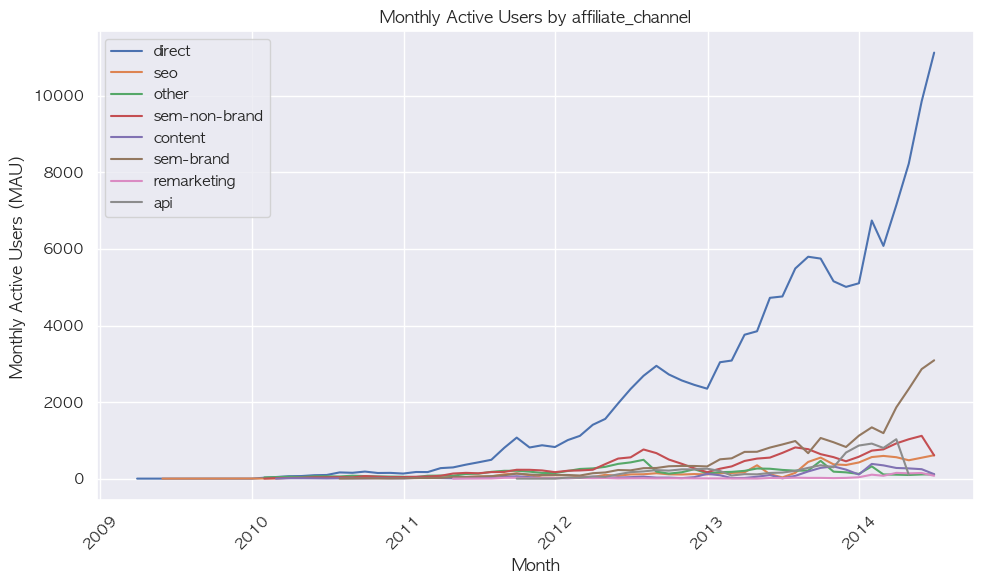

In [17]:
plt.figure(figsize=(10, 6))
# 각 signup_app 별로 선 그래프 그리기
for app in mau['affiliate_channel'].unique():
    app_data = mau[mau['affiliate_channel'] == app]
    plt.plot(app_data['month'], app_data['MAU'], label=app)

# 그래프 레이블과 타이틀 설정
plt.xlabel('Month')
plt.ylabel('Monthly Active Users (MAU)')
plt.title('Monthly Active Users by affiliate_channel')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

## MAU 분석
### 전체적인 추세
- 전체 성장: 그래프에서 볼 수 있듯이, 전체 MAU는 2012년 이후 꾸준히 증가하고 있으며, 특히 2013년 이후 급격히 증가하고 있습니다. 이는 Airbnb의 사용자 기반이 해당 기간 동안 빠르게 성장했음을 나타냅니다.

### 채널별 분석
- direct (직접 방문): 가장 높은 비중을 차지하며, 시간이 지남에 따라 급격히 증가하고 있습니다. 2013년 이후 MAU가 급격히 증가하면서 사용자의 신뢰와 인지도가 크게 상승했음을 보여줍니다.

- seo (검색 엔진 최적화): 지속적인 증가세를 보입니다. 검색 엔진을 통한 자연 검색 결과의 유입이 꾸준히 증가하고 있음을 알 수 있습니다.

- sem-non-brand (비브랜드 검색 광고): 2012년 이후 점진적으로 증가하고 있습니다. 비브랜드 키워드를 통한 검색 광고가 새로운 사용자 유입에 지속적으로 기여하고 있습니다.

- sem-brand (브랜드 검색 광고): 점진적으로 증가하는 추세입니다. 브랜드 인지도가 높아짐에 따라 브랜드 검색 광고의 효과도 증가하고 있음을 나타냅니다.

- content (콘텐츠 마케팅): 꾸준한 증가세를 보입니다. 콘텐츠 마케팅을 통한 사용자 유입이 효과적임을 알 수 있습니다.

- remarketing (리마케팅 캠페인): 비교적 낮은 비중이지만, 점진적으로 증가하고 있습니다. 이전 방문자를 대상으로 한 광고 캠페인이 재방문 유도에 효과적임을 보여줍니다.

- api (API): 거의 변동이 없고 낮은 비중을 차지하고 있습니다. API를 통한 유입은 다른 채널에 비해 크지 않음을 나타냅니다.

- other (기타 채널): 다른 채널들에 비해 다소 낮은 비중을 차지하고 있으며, 점진적으로 증가하고 있습니다. 특정한 마케팅 채널이 아닌 기타 경로를 통해 유입된 사용자가 증가하고 있음을 나타냅니다.

### 종합 해석
- 주요 유입 경로: direct와 seo가 여전히 주요 유입 경로로, 이는 사용자의 자연스러운 방문이 많다는 것을 의미합니다.

- 마케팅 효과: sem-non-brand, sem-brand, content, remarketing 등의 마케팅 채널을 통한 사용자 유입이 지속적으로 증가하고 있으며, 이는 마케팅 캠페인이 효과적이라는 것을 보여줍니다.

- 성장세: 전체적으로 모든 채널에서 MAU가 증가하고 있어, Airbnb의 월간 사용자 참여도가 긍정적인 성장세를 보이고 있습니다.

### 추가 해석
- 주요 성장 요인: direct 채널을 통한 사용자의 급격한 증가는 브랜드 인지도와 신뢰도가 크게 상승했음을 나타냅니다. 또한, seo를 통한 꾸준한 유입 증가는 자연 검색 결과에서의 노출이 효과적임을 보여줍니다.

- 마케팅 전략의 성공: sem-non-brand, sem-brand, content, remarketing 등의 채널을 통해 새로운 사용자 유입과 재방문을 유도하는 마케팅 전략이 성공적임을 알 수 있습니다.

# 서비스 고착도(stickiness) 분석
서비스 고착도는 DAU/MAU를 나타내며, 특정 월 동안 얼마나 많은 사용자가 일일 사용자로 활동하는지를 보여준다. 값이 높을수록 사용자가 더 자주 서비스를 이용하고 있음을 나타낸다. 

In [18]:
# timestamp 컬럼을 datetime 형식으로 변환
dau['time'] = pd.to_datetime(dau['time'])
mau['month'] = pd.to_datetime(mau['month'])

In [19]:
monthly_dau = dau
# 월별 DAU 계산
# month와 affiliate_channel로 그룹화하여 월별 평균 DAU를 계산하고, 이를 새로운 데이터프레임으로 저장

monthly_dau['month'] = dau['time'].dt.to_period('M')
monthly_dau = monthly_dau.groupby(['month', 'affiliate_channel'])['DAU'].mean().reset_index()
monthly_dau

,month,affiliate_channel,DAU
0,2009-03,direct,1.000000
1,2009-05,seo,1.000000
2,2009-06,direct,1.000000
3,2009-10,direct,1.000000
4,2009-12,direct,1.000000
...,...,...,...
383,2014-06,other,3.733333
384,2014-06,remarketing,3.000000
385,2014-06,sem-brand,103.033333
386,2014-06,sem-non-brand,20.233333


In [20]:
monthly_mau = mau
# 채널별 MAU 데이터 준비
# month와 affiliate_channel로 그룹화하여 월별 MAU를 계산하고, 이를 새로운 데이터프레임으로 저장

monthly_mau['month'] = mau['month'].dt.to_period('M')
monthly_mau = monthly_mau.groupby(['month', 'affiliate_channel'])['MAU'].sum().reset_index()
monthly_mau

,month,affiliate_channel,MAU
0,2009-03,direct,1
1,2009-05,seo,1
2,2009-06,direct,1
3,2009-10,direct,1
4,2009-12,direct,1
...,...,...,...
383,2014-06,other,112
384,2014-06,remarketing,75
385,2014-06,sem-brand,3091
386,2014-06,sem-non-brand,607


In [21]:
# Stickiness 계산
stickiness = pd.merge(monthly_dau, monthly_mau, on=['month', 'affiliate_channel'])
stickiness['stickiness'] = (stickiness['DAU'] / stickiness['MAU']) * 100


# 2009년 이전 데이터 지우기
stickiness = stickiness[stickiness['month'].dt.year != 2009]
stickiness

,month,affiliate_channel,DAU,MAU,stickiness
5,2010-01,direct,1.411765,24,5.882353
6,2010-01,other,1.777778,32,5.555556
7,2010-01,sem-non-brand,2.000000,2,100.000000
8,2010-01,seo,1.333333,4,33.333333
9,2010-02,content,1.000000,1,100.000000
...,...,...,...,...,...
383,2014-06,other,3.733333,112,3.333333
384,2014-06,remarketing,3.000000,75,4.000000
385,2014-06,sem-brand,103.033333,3091,3.333333
386,2014-06,sem-non-brand,20.233333,607,3.333333


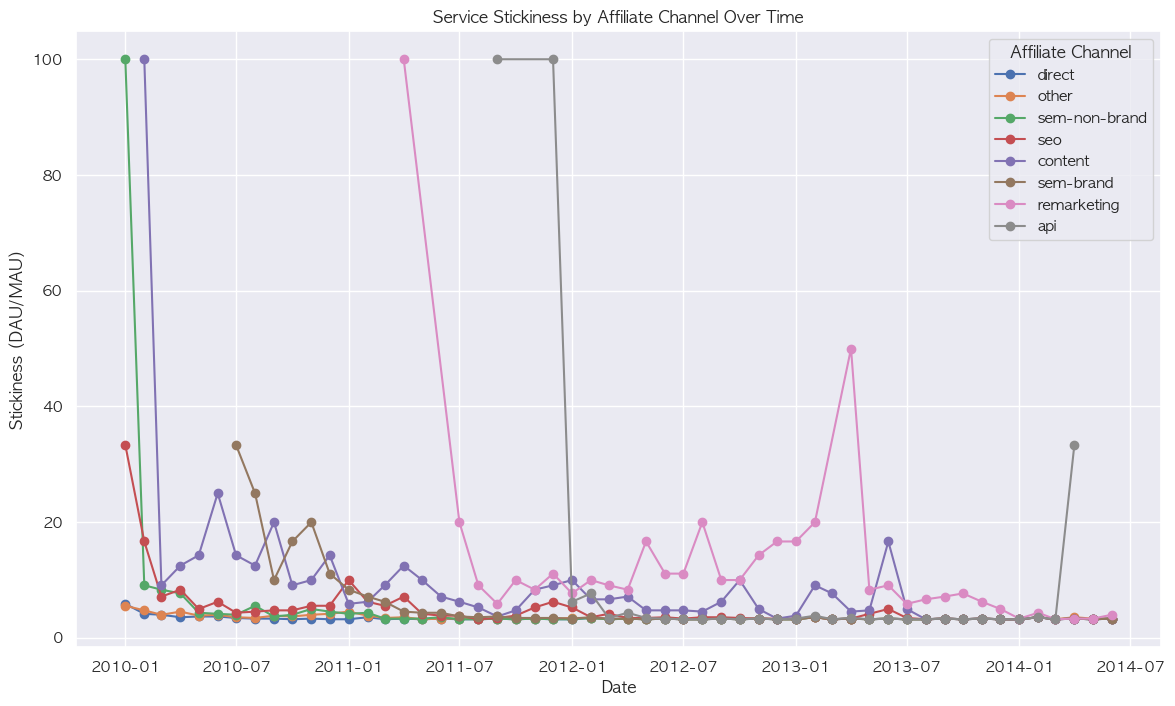

In [22]:
# 채널별 Stickiness 시각화
plt.figure(figsize=(14, 8))

for channel in stickiness['affiliate_channel'].unique():
    channel_data = stickiness[stickiness['affiliate_channel'] == channel]
    plt.plot(channel_data['month'].dt.to_timestamp(), channel_data['stickiness'], marker='o', label=channel)

plt.title('Service Stickiness by Affiliate Channel Over Time')
plt.xlabel('Date')
plt.ylabel('Stickiness (DAU/MAU)')
plt.legend(title='Affiliate Channel')
plt.grid(True)
plt.show()


- direct (직접 방문) : Stickiness가 2010년 초반에는 높았지만, 이후 급격히 감소하고 안정화되었습니다.
이는 초기에는 직접 방문하는 사용자가 매우 자주 방문했지만, 시간이 지남에 따라 직접 방문하는 사용자들이 비교적 덜 자주 방문하게 되었음을 나타냅니다.

- seo (검색 엔진 최적화) : Stickiness가 초기에는 매우 높았지만, 이후 급격히 감소했습니다.
이는 초기에는 검색 엔진 최적화를 통해 유입된 사용자가 매우 자주 방문했지만, 시간이 지남에 따라 방문 빈도가 줄어들었음을 의미합니다.

- sem-non-brand (비브랜드 검색 광고)
초기에는 높은 Stickiness를 보였으나, 이후 급격히 감소하고 안정화되었습니다.
이는 비브랜드 검색 광고를 통해 유입된 초기 사용자가 자주 방문했으나, 시간이 지남에 따라 방문 빈도가 줄어들었음을 나타냅니다.

- sem-brand (브랜드 검색 광고)
초기에는 높은 Stickiness를 보였으나, 이후 급격히 감소했습니다.
이는 브랜드 검색 광고를 통해 유입된 초기 사용자가 자주 방문했으나, 시간이 지남에 따라 방문 빈도가 줄어들었음을 의미합니다.

- content (콘텐츠 마케팅)
Stickiness가 초기부터 비교적 낮게 유지되며 큰 변동이 없습니다.
이는 콘텐츠 마케팅을 통해 유입된 사용자가 자주 방문하지 않음을 나타냅니다.

- remarketing (리마케팅 캠페인)
Stickiness가 초기에는 매우 높았지만, 이후 급격히 감소하고 다시 상승하는 경향이 있습니다.
이는 리마케팅 캠페인을 통해 유입된 사용자가 초기에는 매우 자주 방문했으나, 시간이 지남에 따라 방문 빈도가 줄어들었음을 의미합니다. 다만, 중간에 다시 상승하는 경향이 있어, 특정 기간 동안 리마케팅의 효과가 다시 나타났음을 알 수 있습니다.

- api (API)
Stickiness가 초기에는 매우 높았지만, 이후 급격히 감소했습니다.
이는 API를 통해 유입된 초기 사용자가 매우 자주 방문했으나, 시간이 지남에 따라 방문 빈도가 줄어들었음을 나타냅니다.

- other (기타 채널)
Stickiness가 전체적으로 낮고 큰 변동이 없습니다.
이는 기타 채널을 통해 유입된 사용자가 자주 방문하지 않음을 나타냅니다.

### 종합 해석
- 초기 급격한 변화: 여러 채널에서 Stickiness가 초기에는 매우 높았다가 급격히 감소하는 경향을 보입니다. 이는 초기 유입된 사용자가 자주 방문했으나, 시간이 지나면서 방문 빈도가 줄어들었음을 나타냅니다.

- 안정화 경향: 대부분의 채널에서 Stickiness 지표가 초기 급격한 변동 이후 낮은 수준에서 안정화됩니다. 이는 시간이 지남에 따라 사용자의 방문 빈도가 일정 수준에서 유지됨을 의미합니다.

- 채널별 특성: 리마케팅 캠페인은 특정 기간 동안 Stickiness가 다시 상승하는 경향을 보이며, 이는 리마케팅 캠페인의 특정 효과가 있었음을 시사합니다.